## Early Detection of Alzheimer's Disease ##

This notebook creates a custom Convolution Neural Network (CNN), ALZ19, that distinguishing between images from four classes of Alzheimer's patients with an accuracy of the rate of <span style="text-decoration: underline;">99%</span> on both the validation and test datasets.

The dataset used in training and validating this model consisted of 6,400 brain scan images organized in four subfolders, where each folder denoted the patient's classification. The data was split into 80% training, 10% validation, and 10% testing. Images are consistently aligned brain slices from a top-down perspective in jpeg format. All jpegs were 8-bit grayscale with black backgrounds.

Before this notebook, pre-trained Convolution Neural Networks (CNNs) such as VGG16, VGG19, ResNet, and EfficientNet were tried. It was believed that these models would take advantage of transfer learning and eliminate the need for architecture experimentation; however, these fine-tuned experiments achieved a maximum accuracy ceiling of less than 90%, which may be the result of the significant differences in the underlying training datasets: ImageNet vs. brain scans.

Multiple custom models were attempted. The architectural approach to build a Sequential Model in Keras with convolutional layers for extracting features followed by flattening and dense layers for classification. Pooling layers were added after convolutions to focus on the image's most critical parts. Dropout layers were added to be used during training and turned off during evaluation and deployment. Batch normalization was included after convolution and dense layers.

More details can be found regarding the larger project this notebook was developed in support of at Omdena Challenge: Early Detection of Alzheimer's.

### **Import Libraries** ###

Imports various libraries and tools needed for building, training, evaluating, and visualizing the model.

In [ ]:
# Standard libraries
import os
import multiprocessing
import gdown

# Data processing and numerical operations
import numpy as np

# Machine learning and neural networks
import tensorflow as tf
import tensorflow_hub as hub
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Conv2D, MaxPooling2D
from keras.models import Sequential
from keras.optimizers.legacy import Adam
from keras.preprocessing.image import load_img
from keras.preprocessing.image import ImageDataGenerator

# Image processing
from PIL import Image

# Model selection and data reporting
from sklearn import model_selection
from sklearn.metrics import confusion_matrix, classification_report

# Evaluation and visualization
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow

### **Verify our Machine**

Print our the Tensorflow, Hub version and GPU availability.

In [ ]:
print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

TF version: 2.15.0
Hub version: 0.15.0
GPU is available


### **Download Data** ###

The MRI brain scan data are stored on Google Drive. The subfolders indicated the images classification.

The data has four classes: Mild Demented, Moderate Demented, Non Demented, and Very Mild Demented. Views are aligned and consistent between scans.

In [ ]:
# Specify the path to the data
DATA_DIR = 'brain_scans'

# Check if the extracted folder already exists
# The os.path.isdir function checks if the specified path is an existing directory
if os.path.isdir(DATA_DIR):
    # If the directory exists, print a message indicating that the files are already extracted
    print('Files and folder already extracted!')
else:
    # If the directory does not exist, download the file using gdown
    # The gdown command downloads a file from Google Drive using the provided URL
    gdown.download('https://drive.google.com/uc?id=1GsgUklIyCuIl1BmoT7X0sEVN7ZeFabpM', 'brain_scans.zip', quiet=False)

    # Unzip the downloaded file
    # The unzip command extracts files from the zip file named 'brain_scans.zip'
    !unzip brain_scans.zip

    # After extraction, print a confirmation message
    print('Files extracted!')

Files and folder already extracted!


### Load Data ###

We use ImageDataGenerator to load, preprocess, and scale our image data so that the images are suitable for training a machine learning model.

The images and labels are then organized into training, validation, and test sets; to train and evaluate the performance of our model.

To better understand our dataset, we gather information about the classes of images such as the class distributions and name, as well as their properties, such as size and color channels.

We also plot a random image from each types.

In [ ]:
# Specify constants related to the dataset
SEED = 42  # Seed for reproducibility
IMG_HEIGHT = 224
IMG_WIDTH = 224
CHANNELS = 3

# Creation of an ImageDataGenerator instance
# ImageDataGenerator is a class in Keras used for real-time data augmentation and normalization.
# It is highly useful for image data preprocessing and augmentation, making the model training more robust.
datagen = ImageDataGenerator(
    rescale=1./255  # The rescale parameter is used for rescaling the pixel values.
    # The below parameters were not used in the final model.
    # rotation_range=10,  # The rotation_range parameter is used for randomly rotating the images.
    # horizontal_flip=True,  # The horizontal_flip parameter is used for randomly flipping half of the images horizontally.
    # vertical_flip=True,  # The vertical_flip parameter is used for randomly flipping half of the images vertically.
    # preprocessing_function=preprocess_image
)

# Create a flow generator for the data
gen = datagen.flow_from_directory(
    DATA_DIR, # Path to the data directory
    target_size = (IMG_HEIGHT, IMG_WIDTH), # Target size of the images (height, width)
    batch_size = 6500,  # Size of the batches
    class_mode = 'categorical', # Type of labels (binary or categorical)
    seed = SEED # Seed for reproducibility
)

# Generate the images and labels from the dataset
images, labels = gen.next()

# Split the dataset into train,val and test sets in two splits
# Split 1: all (100%) -> train_val (90%) + test (10%)
# Split 2: train_val (90%) -> train (80%) + val (10%)
train_val_images, test_images, train_val_labels, test_labels = model_selection.train_test_split(images, labels, test_size = 1/10, random_state=SEED)
train_images, val_images, train_labels, val_labels = model_selection.train_test_split(train_val_images, train_val_labels, test_size = 1/9, random_state=SEED)

# Print the shapes of the train, val, and test sets
print('\nTraining:\t{} \t{}'.format(np.sum(train_labels, axis=0), int(train_labels.sum())))
print('Validation:\t{} \t\t{}'.format(np.sum(val_labels, axis=0), int(val_labels.sum())))
print('Test:\t\t{} \t\t{}'.format(np.sum(test_labels, axis=0), int(test_labels.sum())))
print('Totals:\t\t{} \t{}'.format(np.sum(labels, axis=0), int(labels.sum())))

# Accessing class names and their indices
class_indices = gen.class_indices

# Print class names and indices
print("\nClass names and their indices:", class_indices)

# Print image size and number of channels
print("\nImage size and channel count:", images[0].shape)

Found 6400 images belonging to 4 classes.

Training:	[ 703.   48. 2594. 1775.] 	5120
Validation:	[104.   8. 287. 241.] 		640
Test:		[ 89.   8. 319. 224.] 		640
Totals:		[ 896.   64. 3200. 2240.] 	6400

Class names and their indices: {'MildDemented': 0, 'ModerateDemented': 1, 'NonDemented': 2, 'VeryMildDemented': 3}

Image size and channel count: (224, 224, 3)


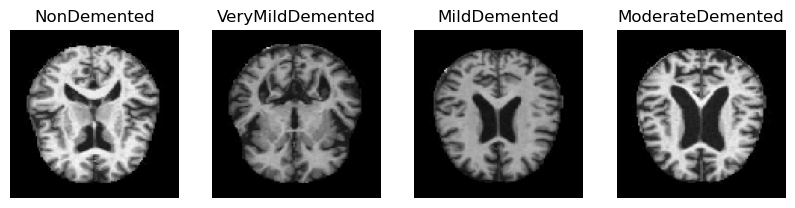

In [ ]:
def load_one_image_per_class(data_dir, target_size=(IMG_HEIGHT, IMG_WIDTH)):
    """
    Load one image from each class in the dataset, in the order of classes 2, 3, 0, 1.

    Args:
    data_dir (str): Directory containing subdirectories for each class, each with its images.
    target_size (tuple): Size to which the images are resized.

    Returns:
    list: A list containing one image from each of the specified classes and their class names.
    """
    images = []
    class_names = []
    # Get all class directories and sort them
    all_classes = [d for d in sorted(os.listdir(data_dir)) if os.path.isdir(os.path.join(data_dir, d))]

    # Specify the order of classes as 2, 3, 0, 1
    class_order = [2, 3, 0, 1]
    selected_classes = [all_classes[i] for i in class_order]

    for class_name in selected_classes:
        class_dir = os.path.join(data_dir, class_name)
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            if os.path.isfile(img_path):  # Check if it's a file
                image = load_img(img_path, target_size=target_size)
                images.append(image)
                class_names.append(class_name)  # Store the class name
                break  # Stop after the first image of the class

    return images, class_names

# Replace 'DATA_DIR' with your dataset's directory path
images, class_names = load_one_image_per_class(DATA_DIR, target_size=(IMG_HEIGHT // 2, IMG_WIDTH // 2))

# Plotting
plt.figure(figsize=(10, 2.5))  # Adjust the figure size as needed (50% smaller)
for i, (image, class_name) in enumerate(zip(images, class_names)):
    plt.subplot(1, 4, i + 1)  # 1 row, 4 columns, ith subplot
    plt.imshow(image)
    plt.title(class_name)  # Set the title to the class name
    plt.axis('off')  # Turn off axis

plt.show()


### **Create the Model** ###

Build a model using TensorFlow and Keras. This section of code defines a function to create a Convolutional Neural Network (CNN), which is commonly used for classifying images.

In [ ]:
DROPOUT = 0.15

def create_alz19_model():
    model = Sequential([
        # First convolutional layer with 64 filters, 3x3 kernel, 'same' padding, and ReLU activation
        Conv2D(64, (3, 3), padding='same', activation='relu'),
        # Max pooling layer with 2x2 pool size to reduce spatial dimensions
        MaxPooling2D(pool_size=(2, 2)),
        # Batch normalization to normalize activations of the previous layer
        BatchNormalization(),
        # Dropout layer for regularization, helps prevent overfitting (dropout rate was increased from 0.25 to 0.5)
        Dropout(DROPOUT),

        # Second convolutional layer with 32 filters, 5x5 kernel
        Conv2D(32, (5, 5), padding='same', activation='relu'),
        # Corresponding max pooling layer
        MaxPooling2D(pool_size=(2, 2)),
        # Batch normalization to normalize activations of the previous layer
        BatchNormalization(),
        # Dropout layer, again for regularization
        Dropout(DROPOUT),

        # Flatten layer to convert 2D feature maps to 1D feature vectors
        Flatten(),

        # First dense (fully connected) layer with 256 neurons and ReLU activation
        Dense(256, activation='relu'),
        # Batch normalization
        BatchNormalization(),
        Dropout(DROPOUT),

        # Second dense layer with 224 neurons
        Dense(256, activation='relu'), # was 224
        # Batch normalization to normalize activations of the previous layer
        BatchNormalization(),
        # Dropout layer
        Dropout(DROPOUT),

        # Third dense layer with 64 neurons
        Dense(64, activation='relu'),
        # Batch normalization
        BatchNormalization(),
        # Dropout layer
        Dropout(DROPOUT),

        # Output dense layer with 4 neurons and softmax activation for multi-class classification
        Dense(4, activation='softmax')
    ])

    return model

### **Train the Model** ###

After deciding on the custom model, experiments were performed and tracked in MLFlow to maximize the model's accuracy. Each round of experiments was based on the most promising previous results.

Key takeaways are listed below.

1. Processing: Various preprocessing techniques were tried with ImageDataGenerator to improve model performance. Rescaling the 8-bit grayscale images from 0-255 was accomplished with rescale=1./255. Horizontal/vertical flips and rotations were tried but did not improve performance. A custom cropping function based on contours did not boost performance.

2. Overfitting: Dropout layers addressed overfitting issues better than Lasso (L1) or Ridge (L2) Regression. Low dropout rates were highly effective in keeping training and validation metrics within a few percentage points in most epochs. Higher dropout rates hurt performance. Dropout layers are after all convolution and dense layers.

3. Learning rate and batch size were important hyperparameters in training this model. An Adam optimizer with a low initial learning rate performed well. The Adam optimizer is an algorithm for first-order gradient-based optimization of stochastic objective functions based on adaptive estimates of lower-order moments. Throughout training, the optimizer adjusts this parameter based on the gradients it computes. Batch sizes of 20 converged and generalized well.

4. Batch normalization: These layers significantly enhanced the model's validation results, likely due to batch normalization's ability to normalize the inputs across mini-batches and help the model generalize better on unseen data.

5. Class imbalance techniques such as class weights and SMOTE attempted to address a limited number of Moderately Demented - Class 1. Neither method was helpful, and the model performed well despite being imbalanced. Fortunately, the model could distinguish it from the other three classes. This result may relate to Class 1 being the most extreme cases of dementia in our dataset.


In [ ]:
METRICS = tf.keras.metrics.Accuracy(name='accuracy')
MONITOR='val_accuracy'
EPOCHS = 200
PATIENCE = 50
LR = 0.002  # The learning rate is a crucial hyperparameter that affects how quickly or slowly a model learns.
BATCH_SIZE = 20 # Batch size determines how many samples will be passed through the network at one time.

# Initialize the history variable to None. This will later be used to store the training history of the model.
history = None

# MLflow setup for experiment tracking.
mlflow.set_tracking_uri("sqlite:///mlflow.db")  # Set the MLflow tracking URI to store experiment data in a local SQLite database.
mlflow.set_experiment(experiment_name='alzheimers')  # Define the name of the experiment under which this run will be logged.
mlflow.autolog()  # Enable automatic logging of parameters, metrics, model artifacts, and more.

# Start an MLflow run for experiment tracking.
with mlflow.start_run():
    # Set a tag for the MLflow run with the current learning rate and batch size for easy identification.
    mlflow.set_tag('mlflow.runName', f'lr: {LR}, bs: {BATCH_SIZE}')

    print(f"\nTraining LR: {LR}, Batch Size: {BATCH_SIZE}\n")

    # Model setup and training.
    # Create an instance of the ALZ16 model (a custom-defined model for your specific task).
    model = create_alz19_model()
    # Build the model specifying the input shape.
    model.build(input_shape=(None, IMG_HEIGHT, IMG_WIDTH, CHANNELS))

    # Compile the model with the Adam optimizer and a specified learning rate.
    # The loss function used is categorical_crossentropy, which is common for multi-class classification tasks.
    model.compile(optimizer=Adam(learning_rate=LR),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Define an EarlyStopping callback to prevent overfitting.
    # This will stop training when the monitored metric (here, 'val_accuracy') stops improving.
    early_stopper = EarlyStopping(monitor='val_accuracy', patience=PATIENCE, restore_best_weights=True)

    # Train the model on the training data while validating on the validation data.
    # The history variable captures the training process metrics.
    history = model.fit(train_images, train_labels,
                        batch_size=BATCH_SIZE,
                        validation_data=(val_images, val_labels),
                        epochs=EPOCHS,
                        callbacks=[early_stopper],
                        verbose=1,
                        use_multiprocessing=True)

    # Clear the TensorFlow session after training to free up GPU memory,
    # which is helpful when running multiple training sessions in a row.
    tf.keras.backend.clear_session()

2024-01-29 14:01:09.611138: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2024-01-29 14:01:09.611169: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2024-01-29 14:01:09.611184: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2024-01-29 14:01:09.611229: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-29 14:01:09.611253: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2024/01/29 14:01:10 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2024/01/29 14:01:10 INFO mlflow.tracking.fluent: Autologging successfully enabled for 


Training LR: 0.002, Batch Size: 20

Epoch 1/200


2024-01-29 14:01:12.379714: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


256/256 [==============================] - 13s 47ms/step - loss: 1.0883 - accuracy: 0.5154 - val_loss: 4.4822 - val_accuracy: 0.4484
Epoch 2/200
256/256 [==============================] - 12s 47ms/step - loss: 0.8737 - accuracy: 0.6008 - val_loss: 3.4510 - val_accuracy: 0.4484
Epoch 3/200
256/256 [==============================] - 12s 48ms/step - loss: 0.6404 - accuracy: 0.7336 - val_loss: 1.3746 - val_accuracy: 0.5375
Epoch 4/200
256/256 [==============================] - 12s 48ms/step - loss: 0.4665 - accuracy: 0.8309 - val_loss: 0.4740 - val_accuracy: 0.8031
Epoch 5/200
256/256 [==============================] - 12s 48ms/step - loss: 0.3680 - accuracy: 0.8732 - val_loss: 0.2881 - val_accuracy: 0.9000
Epoch 6/200
256/256 [==============================] - 12s 48ms/step - loss: 0.2840 - accuracy: 0.9131 - val_loss: 0.2307 - val_accuracy: 0.9234
Epoch 7/200
256/256 [==============================] - 12s 48ms/step - loss: 0.2372 - accuracy: 0.9252 - val_loss: 0.4118 - val_accuracy: 0.84

INFO:tensorflow:Assets written to: /var/folders/_z/9w1967q153jcjpm5hp30gk8r0000gn/T/tmpsds9pbo6/model/data/model/assets
2024/01/29 14:23:01 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/Drew/anaconda3/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils."


### **Loss and Accuracy Plots** ###

This section is for visualizing how certain metrics have changed over the course of training the model.

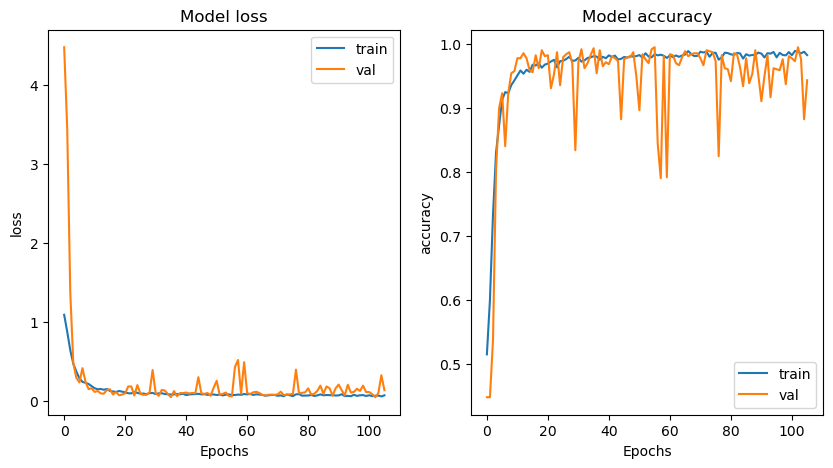

In [ ]:
history.history.items()  # This retrieves key-value pairs in the 'history.history' dictionary.
# Each key is a metric name, and the value is a list containing the metric's value at each epoch during training.

fig, ax = plt.subplots(1, 2, figsize = (10, 5))  # Create a matplotlib figure with two subplots (1 row, 2 columns).
# 'figsize' sets the size of the entire figure.

ax = ax.ravel()  # Flatten the array of axes to easily iterate over them.

# Loop through each metric you want to plot. Here, it's 'loss' and 'accuracy'.
for i, metric in enumerate(["loss", "accuracy"]):
    ax[i].plot(history.history[metric])  # Plot the training metric over epochs.
    ax[i].plot(history.history["val_" + metric])  # Plot the validation metric over epochs.

    ax[i].set_title("Model {}".format(metric))  # Set the title of each subplot as 'Model Loss' and 'Model Accuracy'.
    ax[i].set_xlabel("Epochs")  # Label the x-axis as 'Epochs'.
    ax[i].set_ylabel(metric)  # Label the y-axis with the name of the metric.
    ax[i].legend(["train", "val"])  # Add a legend to distinguish between training and validation metrics.

### **Test the Model** ###

Evaluate the best model from training against the test data set to assess how well the model generalizes on the test data.

The test data was kept separate from the training and validation sets.

In [ ]:
loss, acc = model.evaluate(test_images, test_labels, verbose=2)
print("Accuracy", acc)

20/20 - 1s - loss: 0.0464 - accuracy: 0.9984 - 558ms/epoch - 28ms/step
Accuracy 0.9984375238418579


### **Confusion Matrix** ###

The confusion matrix is a table used to evaluate the performance of a classification model.

Each row of the matrix represents the instances in an actual class, while each column represents the instances in a predicted class.

20/20 [==============================] - 0s 16ms/step

Class names and their indices: {'MildDemented': 0, 'ModerateDemented': 1, 'NonDemented': 2, 'VeryMildDemented': 3}


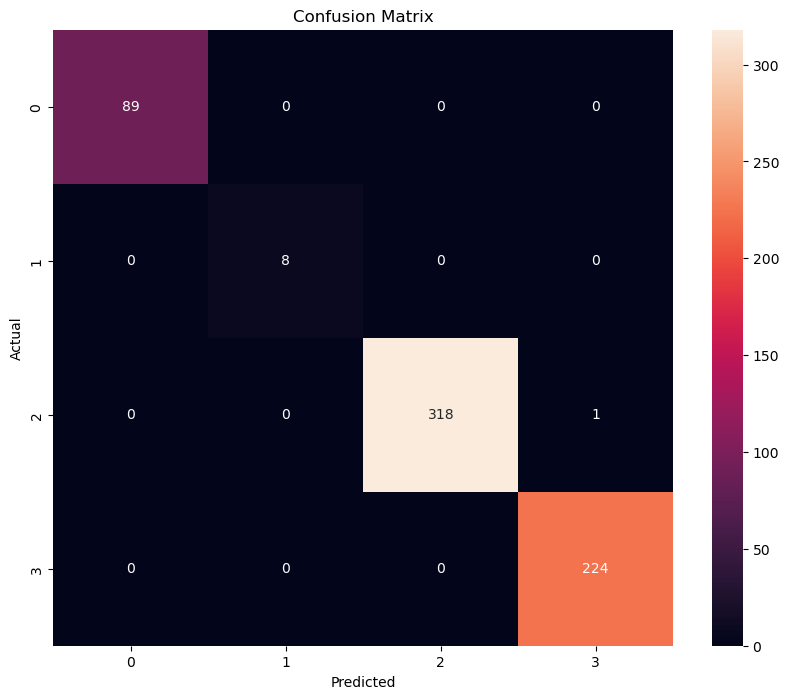

In [ ]:
# Use the trained model to make predictions on the test dataset
predictions = model.predict(test_images)

# The `predictions` are in the form of probabilities for each class.
# The `np.argmax` function is used to find the index of the maximum value in each prediction,
# which corresponds to the most likely class. This converts the probability outputs
# into class labels.
y_pred = np.argmax(predictions, axis=1)

# The test labels (`test_labels`) are likely in a one-hot encoded format,
# where each label is an array with a '1' in the position of the correct class
# and '0's elsewhere. Similar to the predictions, we use `np.argmax` to convert
# these one-hot encoded labels back into actual class labels for comparison.
# This is necessary for evaluating the model's performance using metrics
# like accuracy, confusion matrix, etc.
y_true = np.argmax(test_labels, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plotting the confusion matrix (optional)
# The following code is for visualizing the confusion matrix using matplotlib and seaborn.
plt.figure(figsize=(10, 8))  # Set the size of the figure for the plot

# Create a heatmap using seaborn to visualize the confusion matrix.
# 'cm' is the confusion matrix to be visualized.
# 'annot=True' displays the numbers in the squares.
# 'fmt="d"' means the numbers are formatted as integers.
sns.heatmap(cm, annot=True, fmt="d")

# Labeling the axes and title of the plot.
# 'Actual' for the y-axis represents the true classes of the data.
# 'Predicted' for the x-axis represents the model's predictions.
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')

# Print class names and indices
print("\nClass names and their indices:", class_indices)

# Display the plot.
plt.show()

### **Classification Report** ###

The classification report is a performance evaluation metric in machine learning. It is used to show the main classification metrics precision, recall, and f1-score on a per-class basis. The reported averages include macro average (averaging the unweighted mean per label), weighted average (averaging the support-weighted mean per label), and sample average (only for multilabel classification).

'y_true' are the true labels of the data, and 'y_pred' are the predicted labels by the model.

In [ ]:
# Generate a classification report
test_report = classification_report(y_true, y_pred)

# Print the classification report.
# This is useful for getting a quick understanding of the model's effectiveness
# and can highlight which classes are performing well or poorly.
print(test_report)

# Print class names and indices
print("\nClass names and their indices:", class_indices)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        89
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00       319
           3       1.00      1.00      1.00       224

    accuracy                           1.00       640
   macro avg       1.00      1.00      1.00       640
weighted avg       1.00      1.00      1.00       640


Class names and their indices: {'MildDemented': 0, 'ModerateDemented': 1, 'NonDemented': 2, 'VeryMildDemented': 3}
